In [1]:

%pylab inline 
import nltk
import ujson
import re
import time
import progressbar

import pandas as pd
from __future__ import print_function
from six.moves import zip, range 

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_auc_score, auc
from sklearn import preprocessing
from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk import PorterStemmer

import nltk
nltk.download('stopwords') #download the latest stopwords

#stopWords = set(stopwords.words('english'))

Populating the interactive namespace from numpy and matplotlib
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sakura\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_jobs_data = pd.read_csv('./jobs_subset1.csv',error_bad_lines=False)

In [3]:
df_jobs_data.head()

,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title
0,Lawyers,23-1011.00,This position is in support of the United Stat...,"Paralegal (Buffalo, NY)"
1,Software Quality Assurance Engineers and Testers,15-1199.01,The successful candidate will maintain and dev...,System Integration / Test Engineer
2,Software Quality Assurance Engineers and Testers,15-1199.01,This position is a Senior System Integration &...,System Integration / Test Engineer Staff
3,Software Quality Assurance Engineers and Testers,15-1199.01,"In this position, candidates may participate i...",Mult Func Fin Analyst
4,Software Quality Assurance Engineers and Testers,15-1199.01,This is a business operations analyst position...,Mult Func Fin Analyst


In [4]:
df_jobs_data.normalizedTitle_onetName.unique()

array(['Lawyers', 'Software Quality Assurance Engineers and Testers',
       'Graduate Teaching Assistants', 'Financial Examiners',
       'Credit Analysts'], dtype=object)

In [5]:
df_jobs_data.title.unique()

array(['Paralegal (Buffalo, NY)', 'System Integration / Test Engineer',
       'System Integration / Test Engineer Staff', ...,
       'JAVA ENGINEER(perm)', 'BSA Analyst', 'AML/KYC Analyst'],
      dtype=object)

In [6]:
df_jobs_data.title.unique().shape

(2496,)

In [7]:
def create_bag_of_words(corpus,
                       NGRAM_RANGE=(0,1),
                       stop_words = None,
                        stem = False,
                       MIN_DF = 0.05,
                       MAX_DF = 0.95,
                       USE_IDF=False):
    """
    Turn a corpus of text into a bag-of-words.
    
    Parameters
    -----------
    corpus: ls
        test of documents in corpus    
    NGRAM_RANGE: tupule
        range of N-gram default (0,1)
    stop_words: ls
        list of commonly occuring words that have little semantic
        value
    stem: bool
        use a stemmer to stem words
    MIN_DF: float
       exclude words that have a frequency less than the threshold
    MAX_DF: float
        exclude words that have a frequency greater than the threshold
    
    
    Returns
    -------
    bag_of_words: scipy sparse matrix
        scipy sparse matrix of text
    features:
        ls of words
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
     
    if stem:
        tokenize = lambda x: [stemmer.stem(i) for i in x.split()]
    else:
        tokenize = None
    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=tokenize, 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stop_words,
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    bag_of_words = vectorizer.fit_transform( corpus ) #transform our corpus is a bag of words 
    features = vectorizer.get_feature_names()

    if USE_IDF:
        NORM = None #turn on normalization flag
        SMOOTH_IDF = True #prvents division by zero errors
        SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
        transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
        #get the bag-of-words from the vectorizer and
        #then use TFIDF to limit the tokens found throughout the text 
        tfidf = transformer.fit_transform(bag_of_words)
        
        return tfidf, features
    else:
        return bag_of_words, features

In [8]:
toy_corpus = ['this is document one', 'this is document two', 'text analysis on documents is fun']
toy_bag_of_words, toy_features = create_bag_of_words(toy_corpus)
print(toy_corpus)
np_bag_of_words = toy_bag_of_words.toarray()
print(np_bag_of_words)
print(toy_features)

['this is document one', 'this is document two', 'text analysis on documents is fun']
[[0 1 0 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 1 1]
 [1 0 1 1 1 0 1 0 0]]
['analysis', 'document', 'documents', 'fun', 'on', 'one', 'text', 'this', 'two']


In [9]:
def get_word_counts(bag_of_words, feature_names):
    """
    Get the ordered word counts from a bag_of_words
    
    Parameters
    ----------
    bag_of_words: obj
        scipy sparse matrix from CounterVectorizer
    feature_names: ls
        list of words
        
    Returns
    -------
    word_counts: dict
        Dictionary of word counts
    """
    np_bag_of_words = bag_of_words.toarray()
    word_count = np.sum(np_bag_of_words,axis=0)
    np_word_count = np.asarray(word_count).ravel()
    dict_word_counts = dict( zip(feature_names, np_word_count) )
    
    orddict_word_counts = OrderedDict( 
                                    sorted(dict_word_counts.items(), key=lambda x: x[1], reverse=True), )
    
    return orddict_word_counts

In [10]:
get_word_counts(toy_bag_of_words, toy_features)

OrderedDict([('document', 2),
             ('this', 2),
             ('analysis', 1),
             ('documents', 1),
             ('fun', 1),
             ('on', 1),
             ('one', 1),
             ('text', 1),
             ('two', 1)])

In [5]:
corpus = list(df_jobs_data['jobDescription'].values) #pull all the jobDescriptions and put them in a numpy array 
corpus

["This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final dispositi

In [12]:
def create_topics(tfidf, features, N_TOPICS=3, N_TOP_WORDS=5,):
    """
    Given a matrix of features of text data generate topics
    
    Parameters
    -----------
    tfidf: scipy sparse matrix
        sparse matrix of text features
    N_TOPICS: int
        number of topics (default 10)
    N_TOP_WORDS: int
        number of top words to display in each topic (default 10)
        
    Returns
    -------
    ls_keywords: ls
        list of keywords for each topics
    doctopic: array
        numpy array with percentages of topic that fit each category
    N_TOPICS: int
        number of assumed topics
    N_TOP_WORDS: int
        Number of top words in a given topic. 
    """
    
    with progressbar.ProgressBar(max_value=progressbar.UnknownLength) as bar:
        i=0
        lda = LatentDirichletAllocation( n_topics= N_TOPICS,
                                       learning_method='online') #create an object that will create 5 topics
        bar.update(i)
        i+=1
        doctopic = lda.fit_transform( tfidf )
        bar.update(i)
        i+=1
        
        ls_keywords = []
        for i,topic in enumerate(lda.components_):
            word_idx = np.argsort(topic)[::-1][:N_TOP_WORDS]
            keywords = ', '.join( features[i] for i in word_idx)
            ls_keywords.append(keywords)
            print(i, keywords)
            bar.update(i)
            i+=1
            
    return ls_keywords, doctopic
corpus_bag_of_words, corpus_features = create_bag_of_words(corpus)
corpus_features

['00',
 '000',
 '10',
 '100',
 '11',
 '12',
 '15',
 '20',
 '2015',
 '25',
 '30',
 '40',
 '50',
 '500',
 '80',
 '800',
 'aa',
 'abilities',
 'ability',
 'able',
 'about',
 'above',
 'academic',
 'access',
 'accordance',
 'according',
 'accounting',
 'accounts',
 'accredited',
 'accuracy',
 'accurate',
 'achieve',
 'across',
 'act',
 'action',
 'active',
 'activities',
 'addition',
 'additional',
 'administration',
 'administrative',
 'admired',
 'advance',
 'advanced',
 'affirmative',
 'again',
 'against',
 'age',
 'agencies',
 'agency',
 'agile',
 'agreeing',
 'al',
 'all',
 'along',
 'also',
 'an',
 'analysis',
 'analyst',
 'analytical',
 'analyze',
 'and',
 'anos',
 'any',
 'applicable',
 'applicants',
 'application',
 'applications',
 'apply',
 'applying',
 'appropriate',
 'architecture',
 'are',
 'area',
 'areas',
 'around',
 'as',
 'aspects',
 'assessment',
 'assigned',
 'assist',
 'assistance',
 'assistant',
 'assisting',
 'assists',
 'associate',
 'associated',
 'assurance',
 'a

In [13]:
get_word_counts(corpus_bag_of_words, corpus_features)

OrderedDict([('and', 71579),
             ('to', 36554),
             ('the', 34744),
             ('of', 31545),
             ('in', 23690),
             ('with', 16768),
             ('for', 15536),
             ('or', 13457),
             ('experience', 11012),
             ('is', 10078),
             ('de', 8539),
             ('as', 8209),
             ('be', 7056),
             ('on', 6966),
             ('work', 6535),
             ('our', 6494),
             ('will', 5901),
             ('are', 5726),
             ('an', 5664),
             ('job', 5605),
             ('skills', 5302),
             ('software', 5248),
             ('we', 5163),
             ('development', 5032),
             ('you', 4857),
             ('test', 4713),
             ('this', 4567),
             ('all', 4429),
             ('team', 4411),
             ('that', 4241),
             ('ability', 4225),
             ('other', 4191),
             ('required', 4126),
             ('business', 3982),
   

In [14]:
ls_corpus_keywords, corpus_doctopic = create_topics(corpus_bag_of_words, corpus_features)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |                                            #      | 2 Elapsed Time: 0:01:06


0 de, en, la, con, legal
1 and, to, the, of, in
2 and, to, the, of, in


In [15]:
#get rid of the punctuations and set all characters to lowercase
RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters

#get rid of punctuation and make everything lowercase
#the code belows works by looping through the array of text
#for a given piece of text we invoke the `re.sub` command where we pass in the regular expression, a space ' ' to
#subsitute all the matching characters with
#we then invoke the `lower()` method on the output of the re.sub command
#to make all the remaining characters
#the cleaned document is then stored in a list
#once this list has been filed it is then stored in a numpy array

processed_corpus = np.array( [ re.sub(RE_PREPROCESS, ' ', comment).lower() for comment in corpus] )


In [16]:
corpus[0]

"This position is in support of the United States Attorney's Office in Buffalo, NY located at 138 Delaware Avenue. The estimated length of this assignment is through May 31, 2016 with the possibility of extensions. Overtime and travel may be authorized as needed. The Employee will perform the following tasks, but not limited to: *Serves as a primary resource for the office on all aspects of docketing. *Recommends revisions in office procedures to improve the docketing function by expediting case processing, changing codes for data elements, etc. *Reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system. Advises other personnel on appropriate codes for unprecedented cases. Explains the operation of the system and importance of timely information to new attorneys and support staff. *Responsibility for developing/maintaining automated records for the criminal and civil case workload from initial referral to final dispositio

In [17]:
processed_corpus[0]

'this position is in support of the united states attorney s office in buffalo ny located at   delaware avenue the estimated length of this assignment is through may     with the possibility of extensions overtime and travel may be authorized as needed the employee will perform the following tasks but not limited to serves as a primary resource for the office on all aspects of docketing recommends revisions in office procedures to improve the docketing function by expediting case processing changing codes for data elements etc reviews reports to identify recurring errors and trains new employees in the operation and use of the case tracking system advises other personnel on appropriate codes for unprecedented cases explains the operation of the system and importance of timely information to new attorneys and support staff responsibility for developing maintaining automated records for the criminal and civil case workload from initial referral to final disposition regularly inputs new i

In [18]:
tokens = processed_corpus[0].split()
eng_stopwords =  stopwords.words('english')
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,stop_words=eng_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)

In [19]:
top_20_words = list(dict_processed_word_counts.keys())[:20]
domain_specific_stopwords = eng_stopwords + top_20_words
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords)
dict_processed_word_counts = get_word_counts(processed_bag_of_words, processed_features)

In [20]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |       #                                           | 2 Elapsed Time: 0:00:40


0 systems, engineering, design, status, technical
1 en, la, con, el, experiencia
2 legal, compliance, time, provide, medical


In [21]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 5,
                                                      N_TOP_WORDS= 10)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |                      #                            | 4 Elapsed Time: 0:00:48


0 legal, compliance, including, company, financial, strong, credit, risk, clients, support
1 medical, laboratory, health, care, procedures, duties, services, training, hours, clinical
2 en, la, con, el, experiencia, pruebas, para, trabajo, que, las
3 engineering, systems, design, status, technical, engineer, data, system, product, support
4 robert, apply, half, applicants, legal, time, applying, please, openings, opportunity


In [22]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |     #                                             | 9 Elapsed Time: 0:00:50


0 engineering, design, systems, engineer, technical, system, tools, integration, product, data, computer, working, new, products, technologies
1 en, la, con, el, experiencia, pruebas, para, trabajo, que, las, por, anos, los, al, del
2 medical, healthcare, services, health, care, training, insurance, benefits, employees, company, federal, life, state, provide, plan
3 laboratory, lab, assistant, medical, patient, clinical, care, health, patients, hours, preferred, time, shift, schedule, location
4 legal, law, credit, compliance, counsel, corporate, matters, including, financial, attorney, company, litigation, issues, regulatory, strong
5 status, information, gender, national, opportunity, religion, race, origin, sexual, color, equal, systems, disability, protected, age
6 compliance, project, product, new, process, ensure, support, technical, services, strong, including, working, risk, related, data
7 robert, half, apply, applicants, openings, authorized, applying, contact, staffing, com,

In [23]:
stemmer = PorterStemmer()
print(stemmer.stem('lies'))
print(stemmer.stem("lying"))
print(stemmer.stem('systematic'))
print(stemmer.stem("running"))

lie
lie
systemat
run


In [24]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True)
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |                          #                        | 9 Elapsed Time: 0:01:03


0 busi, manag, servic, experi, client, develop, partner, profession, global, includ, support, opportun, skill, plan, abil
1 requir, posit, thi, applic, perform, duti, abil, time, assist, employ, may, includ, experi, skill, inform
2 appli, robert, half, thi, state, opportun, applic, compani, compens, provid, author, open, experi, candid, profession
3 develop, experi, softwar, technolog, product, engin, design, skill, new, technic, autom, thi, qualiti, servic, data
4 medic, patient, laboratori, provid, care, servic, health, clinic, requir, lab, assist, healthcar, hospit, train, experi
5 en, la, con, el, experiencia, prueba, para, ano, lo, trabajo, que, al, conocimiento, por, empresa
6 complianc, financi, credit, manag, account, busi, intern, risk, respons, skill, bank, financ, compani, abil, custom
7 requir, qualiti, experi, manag, process, system, product, develop, project, plan, abil, perform, knowledg, document, review
8 experi, engin, develop, softwar, system, statu, requir, applic, 

In [25]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2))
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |                  #                                | 9 Elapsed Time: 0:01:09


0 develop, experi, softwar, engin, system, design, requir, product, qualiti, technolog, applic, skill, autom, technic, tool
1 busi, develop, experi, servic, manag, skill, opportun, custom, product, us, partner, microsoft, global, sale, intern
2 manag, requir, abil, experi, complianc, skill, qualiti, process, respons, review, perform, knowledg, ensur, includ, relat
3 appli, compani, compens, provid, com, thi, industri, robert half, open, fortun, competit, employ f, client, f disabl, admir compani
4 half, robert, credit, robert half, author, applic appli, appli, state, account, opportun, role, thi, open author, offic, applic
5 system, experi, engin, softwar, develop, requir, statu, year, program, applic, employ, nation, protect, qualif, regard race
6 statu, employ, disabl, gender, opportun, protect, inform, equal, race, religion, nation origin, veteran, thi, origin, ani
7 en, la, con, el, experiencia, prueba, para, ano, lo, trabajo, que, conocimiento, al, por, empresa
8 legal, law, provi

In [26]:
processed_bag_of_words, processed_features = create_bag_of_words(processed_corpus,
                                                                 stop_words=domain_specific_stopwords,
                                                                 stem=True,
                                                                 NGRAM_RANGE=(0,2),
                                                                 USE_IDF = True)
dict_word_counts = get_word_counts(processed_bag_of_words,
                   processed_features)


In [27]:
processed_keywords, processed_doctopic = create_topics(processed_bag_of_words, 
                                                       processed_features, 
                                                      N_TOPICS = 10,
                                                      N_TOP_WORDS= 15)

/ |#                                                  | 0 Elapsed Time: 0:00:00C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)
| |                #                                  | 9 Elapsed Time: 0:01:09


0 softwar, engin, develop, system, qualiti, autom, design, experi, tool, softwar develop, softwar engin, technic, technolog, assur, product
1 statu, gender, race, religion, nation origin, sexual, color, race color, sexual orient, origin, ident, veteran statu, gender ident, employ, protect
2 complianc, legal, manag, busi, risk, regulatori, abil, counsel, review, issu, financi, law, credit, corpor, regul
3 patient, medic, laboratori, clinic, care, health, lab, healthcar, hospit, shift, physician, high school, assist, diploma, school diploma
4 duti, complet, student, may, posit, hour, pleas, follow, requir, post, thi, time, date, assist, state
5 countri usa, electr, leader, secur, candid, electr engin, clearanc, engin, desir, advanc, mission, oper, intellig, space, system
6 grumman, northrop grumman, northrop, eeo, disabl ani, divers workforc, aa, citizenship requir, workforc, commit hire, retain, protect class, eeo aa, u citizenship, make decis
7 en, la, con, experiencia, el, ano, prueba

In [28]:
ls_topic_id = [np.argsort(processed_doctopic[comment_id])[::-1][0] for comment_id in range(len(corpus))]
df_jobs_data['topic_id'] = ls_topic_id #add to the dataframe so we can compare with the job titles


In [29]:
topic_num = 0
print(processed_keywords[topic_num])
df_jobs_data[ df_jobs_data.topic_id == topic_num ].head(10)


softwar, engin, develop, system, qualiti, autom, design, experi, tool, softwar develop, softwar engin, technic, technolog, assur, product


,normalizedTitle_onetName,normalizedTitle_onetCode,jobDescription,title,topic_id
9,Software Quality Assurance Engineers and Testers,15-1199.01,About LM: Lockheed Martins Defense and Intelli...,Software Quality Engineer SAFe,0
10,Software Quality Assurance Engineers and Testers,15-1199.01,Understand Customer Software User Stories. Cla...,Mid Level Software Developer,0
30,Software Quality Assurance Engineers and Testers,15-1199.01,This Capability Area Associate Analyst is assi...,System Integration/Test Engineer,0
31,Software Quality Assurance Engineers and Testers,15-1199.01,Cloud Services Software Developer to support t...,Cloud Services Software Development - Schrieve...,0
33,Graduate Teaching Assistants,25-1191.00,Database Administrator for Joint Strike Fighte...,Staff DBA / F-35 ALIS / Hill AFB,0
38,Software Quality Assurance Engineers and Testers,15-1199.01,Serve as a test engineer in a fast-paced envir...,"Test Engineer, Arlington, VA",0
39,Software Quality Assurance Engineers and Testers,15-1199.01,The team provides focused agile software devel...,"Test Engineer, Stafford, VA",0
40,Software Quality Assurance Engineers and Testers,15-1199.01,The team provides focused agile software devel...,"Test Engineer - Stafford, VA",0
43,Software Quality Assurance Engineers and Testers,15-1199.01,Test Engineer for GCSS-MC Oracle R12 upgrade. ...,Test Engineer Stf,0
54,Software Quality Assurance Engineers and Testers,15-1199.01,# Job Description Quality Engineer QUALIFICATI...,Quality Engineer (Guelph Plants),0


In [30]:
df_train = pd.read_csv('./train_corpus_document_tagging.csv',error_bad_lines=False)
df_test = pd.read_csv('./test_corpus_document_tagging.csv',error_bad_lines=False)

In [31]:
df_train.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,96011,Credit Analysts,/Join a financial group thats as committed to ...
1,355594,Credit Analysts,"for fastest consideration on this position, pl..."
2,118598,Credit Analysts,As a Credit Analyst youll be responsible for c...
3,107794,Credit Analysts,We are a specialty retailer offering the very ...
4,40010,Credit Analysts,Title: KYC Remediation Team Analyst II Locatio...


In [32]:
df_train['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [33]:
Counter(df_train['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 51, 'Financial Examiners': 51})

In [34]:
df_test.head()

,Unnamed: 0,normalizedTitle_onetName,jobDescription
0,356466,Credit Analysts,Collections Analyst to monitor and follow up o...
1,314705,Credit Analysts,"Credit Analyst **Location:** LAVERGNE, TN **Sa..."
2,84895,Credit Analysts,Deputy Head of Credit/Senior Credit Officer - ...
3,194749,Credit Analysts,Dresden Partners cuenta con 10 anos de experie...
4,351689,Credit Analysts,Degreed accountant with manufacturing experien...


In [35]:
df_test['normalizedTitle_onetName'].unique()

array(['Credit Analysts', 'Financial Examiners'], dtype=object)

In [36]:
Counter(df_test['normalizedTitle_onetName'].values)

Counter({'Credit Analysts': 77, 'Financial Examiners': 77})

In [37]:
train_labels = df_train.normalizedTitle_onetName.values
train_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])
test_labels = df_test.normalizedTitle_onetName.values
test_corpus = np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])
labels = np.append(train_labels, test_labels)

In [38]:
train_corpus

array([' join a financial group thats as committed to your future as you are at mufg we share a vision for our future we share our successes and we strive to bring out the best in each other in everything we do our     diverse colleagues are connected by a common ambition to create change for the betterfrom forging more dynamic career paths to driving progress in our communities to continuously reshaping the standards of global financial services positive impact starts here see the change you can make as we strive to become the worlds most trusted financial group job summary as a member of the credit stress testing team this role is involved in all aspects of model development implementation and maintenance in a challenging but intellectually interesting and collegial environment in support of the banks overall credit risk management credit risk analyst assists in the development and management of a wide ranging inventory of models covering all aspects of credit loss analysis including

In [39]:
ANALYZER = "word" #unit of features are single words rather then phrases of words 
STRIP_ACCENTS = 'unicode'
TOKENIZER = None
NGRAM_RANGE = (0,2) #Range for pharases of words
MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

vectorizer = CountVectorizer(analyzer=ANALYZER,
                            tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                            ngram_range=NGRAM_RANGE,
                            stop_words = stopwords.words('english'),
                            strip_accents=STRIP_ACCENTS,
                            min_df = MIN_DF,
                            max_df = MAX_DF)

In [40]:
NORM = None #turn on normalization flag
SMOOTH_IDF = True #prvents division by zero errors
SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
USE_IDF = True #flag to control whether to use TFIDF

transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)
d2vtransformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

#get the bag-of-words from the vectorizer and
#then use TFIDF to limit the tokens found throughout the text 
start_time = time.time()
train_bag_of_words = vectorizer.fit_transform( train_corpus ) #using all the data on for generating features!! Bad!
test_bag_of_words = vectorizer.transform( test_corpus )
if USE_IDF:
    train_tfidf = transformer.fit_transform(train_bag_of_words)
    test_tfidf = transformer.transform(test_bag_of_words)
features = vectorizer.get_feature_names()
print('Time Elapsed: {0:.2f}s'.format(
        time.time()-start_time))

Time Elapsed: 0.53s


In [41]:
#relabel our labels as a 0 or 1
le = preprocessing.LabelEncoder() 
le.fit(labels)
labels_binary = le.transform(labels)
#print(labels_binary)

In [60]:
train_size = df_train.shape[0]
train_set_idx = np.arange(0,train_size)
test_set_idx = np.arange(train_size, len(labels))
train_labels_binary = labels_binary[train_set_idx]
test_labels_binary = labels_binary[test_set_idx]


In [43]:
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(train_tfidf, labels_binary[train_set_idx]) #train the classifer to get the model
y_score = mdl.predict_proba( test_tfidf ) #score of the document being an ad for Credit or Financial Analyst

In [44]:
def plot_precision_recall_n(y_true, y_prob, model_name):
    """
    y_true: ls
        ls of ground truth labels
    y_prob: ls
        ls of predic proba from model
    model_name: str
        str of model name (e.g, LR_123)
    """
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax1.set_ylim(0,1.05)
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax2.set_ylim(0,1.05)
    
    name = model_name
    plt.title(name)
    plt.show()

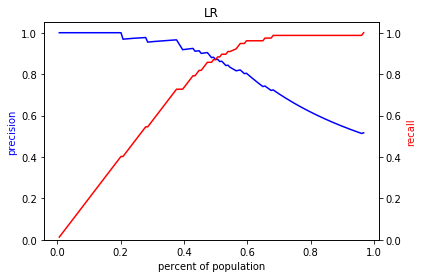

In [45]:
plot_precision_recall_n(labels_binary[test_set_idx], y_score[:,1], 'LR')

In [46]:
def plot_precision_recall(y_true,y_score):
    """
    Plot a precision recall curve
    
    Parameters
    ----------
    y_true: ls
        ground truth labels
    y_score: ls
        score output from model
    """
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true,y_score[:,1])
    plt.plot(recall_curve, precision_curve)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    auc_val = auc(recall_curve,precision_curve)
    print('AUC-PR: {0:1f}'.format(auc_val))
    plt.show()
    plt.clf()

AUC-PR: 0.947871


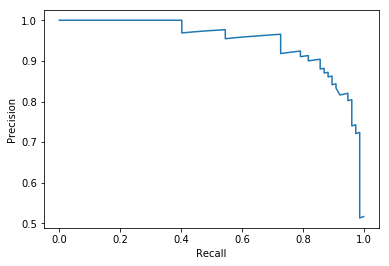

In [47]:
plot_precision_recall(labels_binary[test_set_idx],y_score)

In [48]:
def display_feature_importances(coef,features, labels, num_features=10):
    """
    output feature importances
    
    Parameters
    ----------
    coef: numpy
        feature importances
    features: ls 
        feature names
    labels: ls
        labels for the classifier
    num_features: int
        number of features to output (default 10)
    
    Example
    --------
    
    
    """
    coef = mdl.coef_.ravel()

    dict_feature_importances = dict( zip(features, coef) )
    orddict_feature_importances = OrderedDict( 
                                    sorted(dict_feature_importances.items(), key=lambda x: x[1]) )

    ls_sorted_features  = list(orddict_feature_importances.keys())

    num_features = 10
    label0_features = ls_sorted_features[:num_features] 
    label1_features = ls_sorted_features[-num_features:] 

    print(labels[0],label0_features)
    print(labels[1], label1_features)

In [49]:
display_feature_importances(mdl.coef_.ravel(), features, ['Credit Analysts','Financial Examiner'])

Credit Analysts ['credit', 'trabajo', 'product', 'customer', 'long term', 'customers', 'portfolio', 'de credito', 'manager', 'missing']
Financial Examiner ['plus', 'global', 'officer', 'fraud', 'local', 'review officer', 'como', 'national bank', 'program', 'compliance']


In [50]:
def create_test_train_bag_of_words(train_corpus, test_corpus):
    """
    Create test and training set bag of words
    
    
    Parameters
    ----------
    train_corpus: ls
        ls of raw text for text corpus.
    test_corpus: ls
        ls of raw text for train corpus. 
        
    Returns
    -------
    (train_bag_of_words,test_bag_of_words): scipy sparse matrix
        bag-of-words representation of train and test corpus
    features: ls
        ls of words used as features. 
    """
    #parameters for vectorizer 
    ANALYZER = "word" #unit of features are single words rather then phrases of words 
    STRIP_ACCENTS = 'unicode'
    TOKENIZER = None
    NGRAM_RANGE = (0,2) #Range for pharases of words
    MIN_DF = 0.01 # Exclude words that have a frequency less than the threshold
    MAX_DF = 0.8  # Exclude words that have a frequency greater then the threshold 

    vectorizer = CountVectorizer(analyzer=ANALYZER,
                                tokenizer=None, # alternatively tokenize_and_stem but it will be slower 
                                ngram_range=NGRAM_RANGE,
                                stop_words = stopwords.words('english'),
                                strip_accents=STRIP_ACCENTS,
                                min_df = MIN_DF,
                                max_df = MAX_DF)
    
    NORM = None #turn on normalization flag
    SMOOTH_IDF = True #prvents division by zero errors
    SUBLINEAR_IDF = True #replace TF with 1 + log(TF)
    USE_IDF = True #flag to control whether to use TFIDF

    transformer = TfidfTransformer(norm = NORM,smooth_idf = SMOOTH_IDF,sublinear_tf = True)

    #get the bag-of-words from the vectorizer and
    #then use TFIDF to limit the tokens found throughout the text 
    train_bag_of_words = vectorizer.fit_transform( train_corpus ) 
    test_bag_of_words = vectorizer.transform( test_corpus )
    if USE_IDF:
        train_tfidf = transformer.fit_transform(train_bag_of_words)
        test_tfidf = transformer.transform(test_bag_of_words)
    features = vectorizer.get_feature_names()

    
    return train_tfidf, test_tfidf, features

C:\Users\Sakura\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


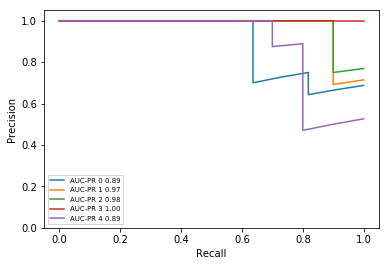

In [51]:
from sklearn.cross_validation import StratifiedKFold
cv = StratifiedKFold(train_labels_binary, n_folds=5)
train_labels_binary = le.transform(train_labels)
for i, (train,test) in enumerate(cv):
    cv_train = train_corpus[train]
    cv_test = train_corpus[test]
    bag_of_words_train, bag_of_words_test, feature_names = create_test_train_bag_of_words(cv_train, 
                                                                                          cv_test)
    
    probas_ = clf.fit(bag_of_words_train, 
                      train_labels_binary[train]).predict_proba(bag_of_words_test)
    cv_test_labels = train_labels_binary[test]
    
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(cv_test_labels,
                                                                          probas_[:,1])
    auc_val = auc(recall_curve,precision_curve)
    plt.plot(recall_curve, precision_curve, label='AUC-PR {0} {1:.2f}'.format(i,auc_val))
    
plt.ylim(0,1.05)    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left", fontsize='x-small')

In [52]:
num_comments = 2
label0_comment_idx = y_score[:,1].argsort()[:num_comments] #SuicideWatch
label1_comment_idx = y_score[:,1].argsort()[-num_comments:] #depression
test_set_labels = labels[test_set_idx]
#convert back to the indices of the original dataset
top_comments_testing_set_idx = np.concatenate([label0_comment_idx, 
                                               label1_comment_idx])


#these are the 5 comments the model is most sure of 
for i in top_comments_testing_set_idx:
    print(
        u"""{}:{}\n---\n{}\n===""".format(test_set_labels[i],
                                          y_score[i,1],
                                          test_corpus[i]))

Credit Analysts:0.0001549865071857402
---
a client in the northwest suburbs is looking for a credit analyst on a temporary basis as the credit analyst you will be responsible for the following extend credit to new customers by performing preliminary credit analysis in determining customer credit status and reviewing existing customers credit line responsible for entering new accounts into computer system and maintaining all a r account information analyze financial data compile reports and review each assigned account and make recommendations as to the size of the customers credit line responsible for research efforts outbound calling to customers write offs suspension of credit reconciliation of charge backs insure that orders are released in a timely manner and customer balances are collected within terms responsible for account credit reviews order releases credit holds ucc filings reconciling customer accounts and collection on equipment leases and contracts while minimizing bad de

# Running Doc2Vec and comparing its performance with tfidf

In [54]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
df_train = pd.read_csv('./train_corpus_document_tagging.csv',error_bad_lines=False)
df_test = pd.read_csv('./test_corpus_document_tagging.csv',error_bad_lines=False)

RE_PREPROCESS = r'\W+|\d+' #the regular expressions that matches all non-characters

df_train1=pd.DataFrame()
df_test1=pd.DataFrame()
df_train1['jobDescription']=np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_train.jobDescription.values])
df_train1['normalizedTitle_onetName']=df_train.normalizedTitle_onetName.values
df_test1['jobDescription']=np.array( [re.sub(RE_PREPROCESS, ' ', text).lower() for text in df_test.jobDescription.values])
df_test1['normalizedTitle_onetName']=df_test.normalizedTitle_onetName.values

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged1 = df_train1.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['jobDescription']), tags=[r.normalizedTitle_onetName]), axis=1)
test_tagged1 = df_test1.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['jobDescription']), tags=[r.normalizedTitle_onetName]), axis=1)

C:\Users\Sakura\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [55]:
import multiprocessing
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged1.values)])

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged1.values)]), total_examples=len(train_tagged1.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha
    
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors



100%|██████████| 102/102 [00:00<?, ?it/s]


In [56]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged1)
y_test, X_test = vec_for_learning(model_dbow, test_tagged1)
le = preprocessing.LabelEncoder() 
le.fit(y_train)
y_train_binary = le.transform(y_train)
le.fit(y_test)
y_test_binary = le.transform(y_test)


In [57]:
clf = LogisticRegression(penalty='l1')
mdl = clf.fit(X_train, y_train_binary) #train the classifer to get the model
y_score = mdl.predict_proba(X_test) #score of the document being an ad for Credit or Financial Analyst

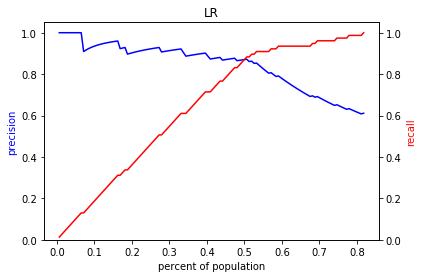

In [58]:
plot_precision_recall_n(y_test_binary, y_score[:,1], 'LR')

AUC-PR: 0.900278


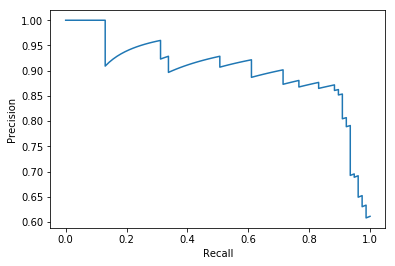

In [59]:
plot_precision_recall(y_test_binary,y_score)